In [88]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [89]:
# Eqn for SHM: d^2y/dt^2 = -k*y => d^2y/dt^2 + k*y = 0, k = w^2
# solution expected: y = A*cos(wt) + B*sin(wt)
k = 4 # k = w^2, w = 2 rad/s
t_max = 3*np.pi  # 3 full cycles
epochs = 5000
LR = 0.003

In [90]:
# Experiment with tanh and sigmoid activation, and simple PINN comparison with PINN with 3 data points
activation_fn = nn.Tanh()  # we can switch between tanh and sigmoid, using nn.Tanh() or nn.Sigmoid()
using_data_points = True  # True or False

t_data_true = torch.tensor([1.5, 3.0, 4.5]).view(-1, 1) # we define 3 data points/times
y_data_true = torch.sin(np.sqrt(k) * t_data_true)       # The real answers for those times assuming y = sin(wt)

In [91]:
class PINN(nn.Module):
    def __init__(self, activation_fn):
        super().__init__()
        self.act = activation_fn
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            self.act,
            nn.Linear(32, 32),
            self.act,
            nn.Linear(32, 32),
            self.act,
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

In [92]:
model = PINN(activation_fn)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [93]:
def calculate_physics_loss(model, t):
    t.requires_grad = True
    y = model(t)
    
    dy_dt = torch.autograd.grad(y, t, torch.ones_like(y), create_graph=True)[0]
    d2y_dt2 = torch.autograd.grad(dy_dt, t, torch.ones_like(dy_dt), create_graph=True)[0]
    
    return torch.mean((d2y_dt2 + k * y)**2) # shm eqn

In [94]:
loss_history = []

for epoch in range(epochs):
    optimizer.zero_grad()

    t_physics = torch.rand(150, 1) * t_max
    loss_phy = calculate_physics_loss(model, t_physics)

    t_0 = torch.tensor([[0.0]], requires_grad=True)
    y_0_pred = model(t_0)
    dy_0 = torch.autograd.grad(y_0_pred, t_0, torch.ones_like(y_0_pred), create_graph=True)[0]

    loss_ic = ((y_0_pred - 0.0)**2 + (dy_0 - 2.0)**2)  # we are setting here y(0)=0 and y'(0)=2 or v(0)=2, since v = wcos(wt) = 2  

    loss_data = 0

    if using_data_points:
        y_data_pred = model(t_data_true)
        loss_data = torch.mean((y_data_pred - y_data_true)**2)* 10  #10 multiplied to give weight

    loss = loss_phy + loss_ic + loss_data
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")
    

Epoch 0, Loss: 6.061188
Epoch 500, Loss: 0.522083
Epoch 1000, Loss: 0.347758
Epoch 1500, Loss: 0.311680
Epoch 2000, Loss: 0.320810
Epoch 2500, Loss: 0.184254
Epoch 3000, Loss: 0.174005
Epoch 3500, Loss: 0.180116
Epoch 4000, Loss: 0.152638
Epoch 4500, Loss: 0.138334


In [95]:
t_test = torch.linspace(0, t_max, 200).view(-1, 1)
y_pred = model(t_test).detach().numpy()
y_true = np.sin(np.sqrt(k) * t_test.numpy())

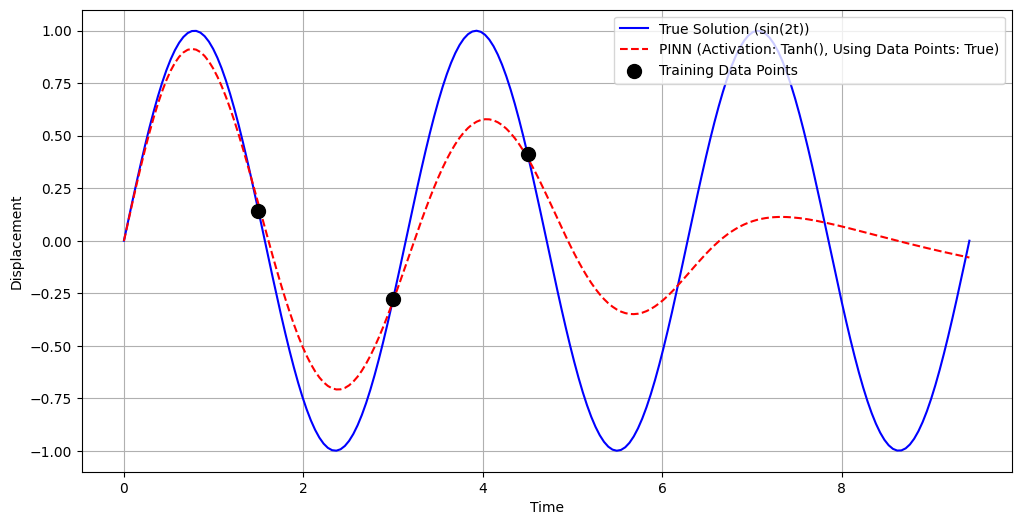

In [96]:
plt.figure(figsize=(12, 6))
plt.plot(t_test, y_true, 'b', label='True Solution (sin(2t))')
plt.plot(t_test, y_pred, 'r--', label=f'PINN (Activation: {activation_fn}, Using Data Points: {using_data_points})')

if using_data_points:
    plt.scatter(t_data_true, y_data_true, color='black', s=100, zorder=5, label='Training Data Points')

plt.xlabel("Time")
plt.ylabel("Displacement")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#So after changing the activation functions, it can be seen that Tanh works better than Sigmoid as it outputs values from -1 to 1 and it's slope extreme mostly around 0 suiting to learn the shm equation. And using just 3 data points significantly helps the model.